In [1]:
import numpy as np
import numpy
import scipy 
from scipy import optimize
from scipy.interpolate import interp1d

from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [2]:
mnpr = 30

r0 = 0.1

dr = 1.001



In [3]:
h = 0.7
Omegam0 = 0.307
kpc = 3.0856*(10**16)
rhocrit = 277.5*(h**2)

eVJ = 1.602*10**(-25)
cc = 2.998*(10**5)
eVkg = eVJ/(cc**2)
gx = 2
hbar = 1.054*(10**(-40))/(kpc)
Msun = 2*(10**30)
fmax = ((mnpr*eVkg)**4)*gx/(2*(2*np.pi*hbar)**3)/Msun
GN = 4.30*(10**(-6))

f=lambda x: np.log1p(x)-1+1/(1+x)
rhoNFW= lambda r,rs,rho0: rho0/((r/rs)*(1+r/rs)**2)


temp=lambda r,rs,rho0: rho0*rs*(-1/((r**2)*(1+r/rs)**2)-2/(r*rs*(1+r/rs)**3))

Psi=lambda r,rs,rho0: 4*GN*np.pi*rho0*(rs**3)*np.log1p(r/rs)/r

In [4]:
def distr_function(Psi_list,temp_list,file_fe_name):
    k=len(temp_list[0])
    fe=[[],[]]
    Ee1=Psi_list[1][0]

    integrand=temp_list[1][1:]/np.sqrt(Ee1-Psi_list[1][1:])
    
    Int1=(Psi_list[0][1]-Psi_list[0][0])*(2*temp_list[1][0])/(np.sqrt(-Psi_list[1][1]+Psi_list[1][0]))
    Int1=Int1+scipy.integrate.trapz(integrand, Psi_list[0][1:])
    
    #with open(file_fe_name, 'w') as file_fe:
    for i in range(1,k-1):
        Ee2=Psi_list[1][i]
        integrand=[]
        integrand=temp_list[1][i+1:]/np.sqrt(Ee2-Psi_list[1][i+1:])

        Int2=(Psi_list[0][i+1]-Psi_list[0][i])*(2*temp_list[1][i])/(np.sqrt(-Psi_list[1][i+1]+Psi_list[1][i]))
        Int2=Int2+scipy.integrate.trapz(integrand, Psi_list[0][i+1:])
        fei=-(Int2-Int1)/(Ee2-Ee1)/(np.sqrt(8)*(np.pi)**2)
        fe[1].append(fei)
        fe[0].append(Ee1)
        #print(np.log10(Ee1), np.log10(fei), sep='   ', end='\n', file=file_fe)
        Int1=Int2
        Ee1=Ee2
    return [np.array(fe[0]), np.array(fe[1])]


def fe_tr(fe):
    imax=0
    for i in range(len(fe[1])):
        if fe[1][i]>fmax:
            imax=i
            #fe[1][i]=fmax
    for j in range(imax+1):
        fe[1][j]=fmax
    return fe
    # if type(fe) is array(array, array)
    # return fe[fe[:,1]>fmax]
    
def rho_tr(fe,Psi_list,file_rho_name):
    rho=[[],[]]
    with open (file_rho_name,'w') as file_rho:
    
        for m in range(len(fe[0])):

            Psix=fe[0][m]

            
            integrand2=[]
            integrand2=fe[1][m:]*np.sqrt(Psix-fe[0][m:])

            rho_temp=-(4)*np.sqrt(2)*np.pi*scipy.integrate.trapz(integrand2,fe[0][m:len(fe[0]):1])

            rho[1].append(rho_temp)

            rho[0].append(Psi_list[0][m])
            print(np.log10(Psi_list[0][m]), np.log10(rho_temp), sep='   ', end='\n', file=file_rho)
    #file_rho.truncate()
    
    
    return [np.array(rho[0]),np.array(rho[1])]

        

def temp_list_f(rho):
    temp_list=[[],[]]
    for i in range(len(rho[0])-1):
        temp_list[1].append(((rho[1][i+1]-rho[1][i])/(rho[0][i+1]-rho[0][i])))
        temp_list[0].append(rho[0][i])
    return [np.array(temp_list[0]),np.array(temp_list[1])]
        
def temp_calc(rho):
    
    
    return np.array([rho[0,:-1],np.diff(rho[1])/np.diff(rho[0])])
        
def Psi_calc(rho,file_Psi_name):
    
    
    M0=np.pi*4/3*rho[1][0]*(rho[0][0])**3
    
    y=4*np.pi*rho[1]*rho[0]**2
    
    M_arr=np.append(np.array([M0]),M0+scipy.integrate.cumtrapz(y,rho[0]) )
        
    Psit=0
    Psi_arr=[[],[]]
    with open(file_Psi_name, 'w') as file_Psi:            
        for i in range(1,len(rho[0])):
            hx=(rho[0][-i]-rho[0][-i-1])
            Psit=Psit+GN*(M_arr[-i]/rho[0][-i]**2+M_arr[-i-1]/rho[0][-i-1]**2)*hx/2
            Psi_arr[1].append(Psit)
            Psi_arr[0].append(rho[0][-i-1])
            print(np.log10(rho[0][-i-1]), np.log10(Psit), sep='   ', end='\n', file=file_Psi)
    
   
    Psi_arr[0]=Psi_arr[0][::-1]
    Psi_arr[1]=Psi_arr[1][::-1]
    
    return np.array(Psi_arr)             

In [5]:
import time
t1=time.clock()

for i in range(1,10):
    file_name_in="Shao-12_fig3_%s.txt"%(i)
    data = [line.split() for line in open(file_name_in, 'r')]

    data=[[float(item1),float(item2)] for item1,item2 in data ]
    data_Shao=list(zip(*data))
    data_Shao=[np.array(data_Shao[0]),np.array(data_Shao[1])]
    popt, pcov=curve_fit(rhoNFW, data_Shao[0][10:],data_Shao[1][10:])
    rs=popt[0]/h
    delt_fit=popt[1]
    rho0=delt_fit*rhocrit
    C200=fsolve(lambda c: 200/3*c**3-delt_fit*f(c),5)

    M200=4*np.pi/3*200*rhocrit*(C200*rs)**3
    
    file_name="Shao-12_fig3_%s"%(i)
    
    rmax1=10*fsolve(lambda x: rhoNFW(x,rs,rho0)-Omegam0*rhocrit,r0)


    kmax1=int((np.log10(rmax1/r0))/((np.log10(dr))))
    
    Psi_list=[[],[]]
    temp_list=[[],[]]
    rx=r0
    
    for j in range(kmax1):

        Psi_list[1].append(Psi(rx,rs,rho0))
        Psi_list[0].append(rx)
        temp_list[1].append(temp(rx,rs,rho0))
        temp_list[0].append(rx)
        rx=rx*dr
    Psi_list=[np.array(Psi_list[0]), np.array(Psi_list[1])]

    temp_list=[np.array(temp_list[0]), np.array(temp_list[1])]
    
    for d in range(6):

        file_fe_name="fe_%s_%s.txt"%(file_name, str(d))
        fe = distr_function(Psi_list,temp_list,file_fe_name)

        fe_tr(fe)

        file_rho_name="rho_tr_%s_%s.txt"%(file_name, str(d))
        rho_list = rho_tr(fe,Psi_list,file_rho_name)

        file_Psi_name="Psi_%s_%s.txt"%(file_name,str(d))


        Psi_list=Psi_calc(rho_list,file_Psi_name)


        temp_list=temp_list_f(rho_list)
        

t2=time.clock() 
print(t2-t1)

C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10


200.5970717611288


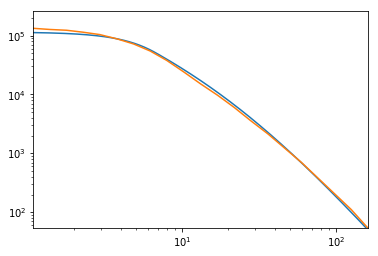

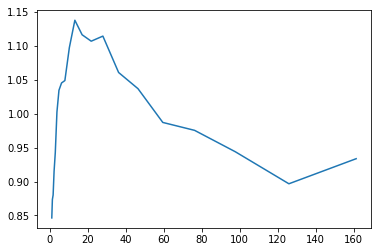

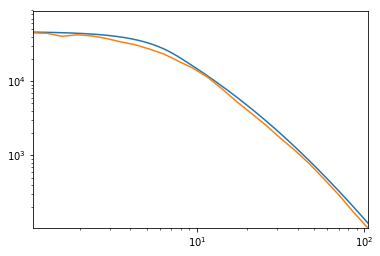

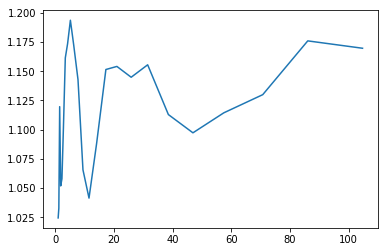

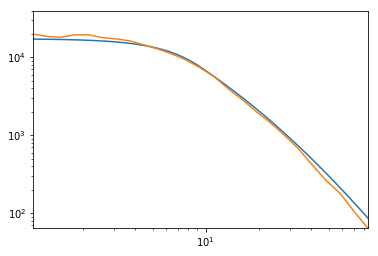

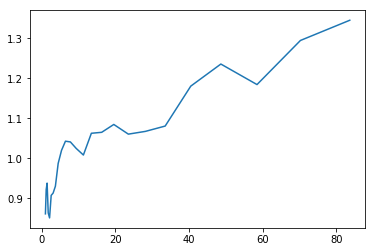

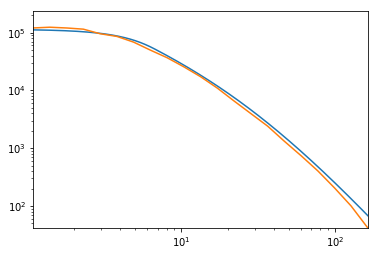

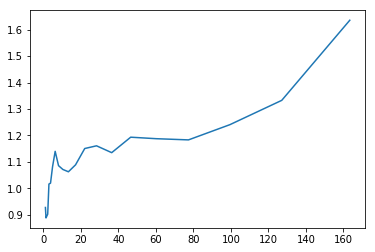

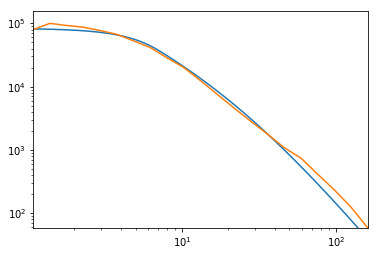

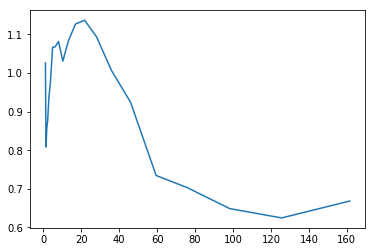

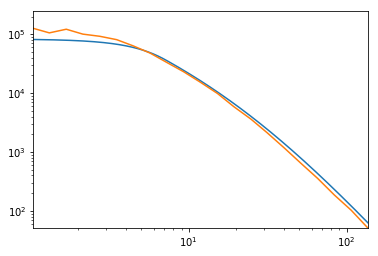

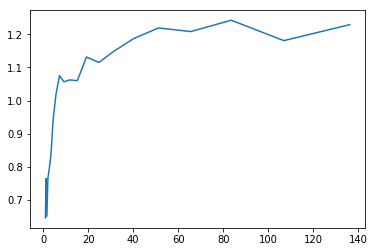

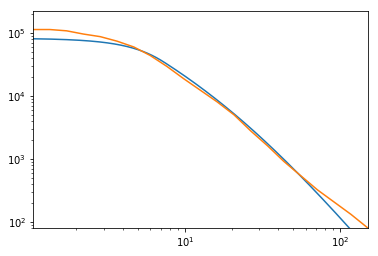

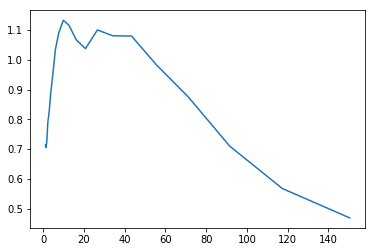

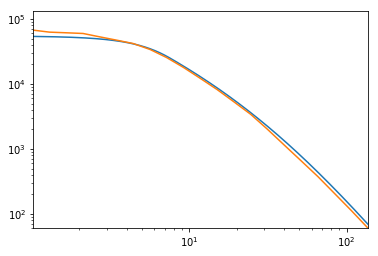

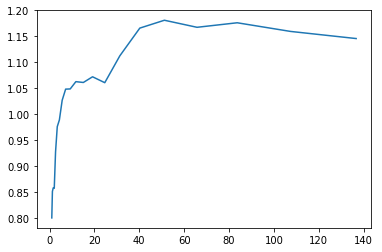

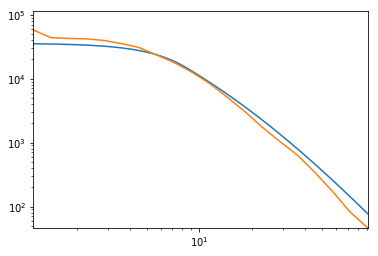

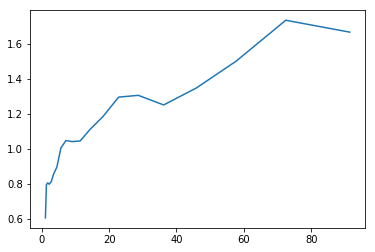

In [6]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
for m in range(1,10):
    
    file_Shao="Shao-12_fig3_tr_%s.txt"%(m)
    file_rho_calc='rho_tr_Shao-12_fig3_%s_5.txt'%(m)
    rho_calc = [line.split() for line in open(file_rho_calc, 'r')]
    data_Shao = [line.split() for line in open(file_Shao,'r')]

    rho_calc=[[10**float(item1)*h,10**float(item2)/rhocrit] for item1,item2 in rho_calc ]
    rho_calc=list(zip(*rho_calc))
    rho_calc_interp=interp1d(rho_calc[0], rho_calc[1], kind='linear')
    

    data_Shao=[[float(item1),float(item2)] for item1,item2 in data_Shao ]
    data_Shao=list(zip(*data_Shao))
    subfig1=plt.loglog(rho_calc[0],rho_calc[1])
    subfig2=plt.loglog(data_Shao[0], data_Shao[1])
    plt.xlim(data_Shao[0][0],data_Shao[0][-1])
    plt.ylim(data_Shao[1][-1],2*data_Shao[1][0])
    plt.show()
    subfig3=plt.plot(data_Shao[0],[rho_calc_interp(data_Shao[0][i])/data_Shao[1][i] for i in range(len(data_Shao[0]))])
    plt.show()
